In [44]:
def extract_every_x_element(lst, x=4):
    result = lst[(x-1)::x]
    return result

def extract_image_ids(list_of_dicts):
    image_ids = [d.get('id') for d in list_of_dicts]
    return image_ids

def extract_dicts_by_ids(list_of_dicts, list_of_ids):
    result_dicts = [d for d in list_of_dicts if d.get('image_id') in list_of_ids]
    return result_dicts

def save_dict_to_json(dictionary, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(dictionary, json_file)

In [43]:
import json
base_path = r"C:\Users\Fabia\Downloads"
files = [r"\results_train.json", r"\results_val.json"]
x = 4
for file in files:
    with open(base_path + file, "r") as f:
        data = json.load(f)
        if "val" in file:
            x = 6
            
        final_images_array = extract_every_x_element(data["images"], x=x)
        final_annotations_array = extract_dicts_by_ids(data["annotations"], extract_image_ids(final_images_array))      
        save_dict_to_json({"info": data["info"], "licenses": data["licenses"], "categories": data["categories"], "images": final_images_array, "annotations": final_annotations_array}, base_path + file.replace(".json", "_reduced.json"))

In [23]:


#final_annotations_array = extract_every_x_element(data["annotations"])
#final_images_array = extract_dicts_by_ids(data["images"], extract_image_ids(final_annotations_array))

In [64]:
import torch
def calculate_distance_between_bounding_boxes(box1, box2, picture_width, picture_height, normalize: bool = True):
    """
    Calculate the Euclidean distance between the middle points of two bounding boxes and scale it in relation to the picture size.

    Args:
        box1 (list or torch.Tensor): A list or tensor representing the first bounding box in the format [x_start, y_start, x_end, y_end].
        box2 (list or torch.Tensor): A list or tensor representing the second bounding box in the format [x_start, y_start, x_end, y_end].
        picture_width (int): The width of the picture.
        picture_height (int): The height of the picture.

    Returns:
        torch.Tensor: The scaled Euclidean distance between the middle points of the two bounding boxes.
    """
    # Convert lists to torch tensors if they are not already
    if isinstance(box1, list):
        box1 = torch.tensor(box1)
    if isinstance(box2, list):
        box2 = torch.tensor(box2)
    if isinstance(picture_width, (int, float)):
        picture_width = torch.tensor(picture_width)
    if isinstance(picture_height, (int, float)):
        picture_height = torch.tensor(picture_height)

    # Extract coordinates from the tensors
    if len(box1) == 4:
        x1_start, y1_start, x1_end, y1_end = box1
        x2_start, y2_start, x2_end, y2_end = box2

        # Calculate the middle points of the bounding boxes
        x1_middle = (x1_start + x1_end) / 2
        y1_middle = (y1_start + y1_end) / 2
        x2_middle = (x2_start + x2_end) / 2
        y2_middle = (y2_start + y2_end) / 2
    else:
        x1_middle, y1_middle = box1
        x2_middle, y2_middle = box2

    # Calculate the Euclidean distance between the middle points
    distance = torch.sqrt((x1_middle - x2_middle) ** 2 + (y1_middle - y2_middle) ** 2)

    # Calculate the relative distance
    # relative_distance = distance / ((picture_width + picture_height) / 2)
    
    max_distance = torch.sqrt(picture_width ** 2 + picture_height ** 2)

    # Normalize the distance
    if normalize:
        return distance / max_distance
    else:
        return distance

In [65]:
import cv2
import numpy as np

def detect_blue_contours(image, lower_blue: np.ndarray =np.array([112, 50, 50]), upper_blue: np.ndarray =np.array([132, 255, 255])):

    # Convert the image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the blue color
#     lower_blue = np.array([120, 50, 50])
#     upper_blue = np.array([132, 255, 255])

    # Create a binary mask for blue regions
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    # Find contours in the mask
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Define the minimum contour area threshold
    min_size_threshold = 15  # Adjust this value according to your needs

    # Filter and process the contours
    blue_box_centers = []
    for contour in contours:
        if cv2.contourArea(contour) > min_size_threshold:
            # Calculate the centroid (middle) of the contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                #blue_box_centers.append((cX, image.shape[1] - cY))
                blue_box_centers.append((cX, cY))
#     # return blue_box_centers
#     # Draw rectangles around the blue boxes (optional)
#     for center in blue_box_centers:
#         cv2.circle(image, center, 5, (0, 0, 255), -1)  # Draw a red circle at the center

#     # Display or save the processed image
#     cv2.imshow('Blue Boxes', image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return blue_box_centers

In [66]:
def calculate_mean_of_tensors(tensor_list):
    """
    Calculate the mean value of a list of tensors.

    Args:
        tensor_list (list of torch.Tensor): A list of tensors to calculate the mean from.

    Returns:
        torch.Tensor: The mean value tensor.
    """
    # Check if the list is empty
    if not tensor_list:
        raise ValueError("The input tensor list is empty.")

    # Initialize a tensor to accumulate the sum
    sum_tensor = torch.zeros_like(tensor_list[0])

    # Sum up all the tensors in the list element-wise
    for tensor in tensor_list:
        sum_tensor += tensor

    # Calculate the mean by dividing the sum by the total number of tensors
    mean_tensor = sum_tensor / len(tensor_list)

    return mean_tensor

In [67]:
def is_within_range(point1, point2, pixelrange=75):
    """
    Check if point1 is within a range around point2.
    """
    x1, y1 = point1
    x2, y2 = point2
    #range_x = abs(x2 * percentage)
    #range_y = abs(y2 * percentage)
    return (x2 - pixelrange <= x1 <= x2 + pixelrange) and (y2 - pixelrange <= y1 <= y2 + pixelrange)


In [91]:
base_image_path = r"E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results"
base_annotation_path = r"D:\Master_Thesis_data\Subtitle_Placement\jsons"

images_folders = [r"\subtitle_position_boxes_middle_of_subtitle_empty\test_11\images",
                 r"\subtitle_position_boxes_middle_of_subtitle_middle\test_10\images"]

annotation_files = [r"\stuff_test2017.json"]

In [92]:
# base_image_path = r"E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results"
# base_annotation_path = r"E:\Python\MasterThesis\AutomaticSubtitlePlacement\data"

# images_folders = [r"\subtitle_position_boxes_middle_of_subtitle_middle\test_7\images", 
#                   r"\subtitle_position_boxes_start_of_subtitle_middle\test_4\images",
#                   r"\subtitle_position_boxes_middle_of_subtitle_start\test_6\images",
#                   r"\subtitle_position_boxes_middle_of_subtitle_empty\test_4\images",
#                   r"\subtitle_position_boxes_start_of_subtitle_start\test_4\images",
#                   r"\subtitle_position_boxes_start_of_subtitle_empty\test_7\images"]

# annotation_files = [r"\subtitle_position_boxes_middle_of_subtitle\jsons\test\results.json",
#                     r"\subtitle_position_boxes_start_of_subtitle\jsons\test\results.json"]

In [93]:
detect_blue_contours(cv2.imread(r"E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_middle_of_subtitle_middle\test_10\images\2250_real_A.png"))

[(127, 229)]

In [94]:
detect_blue_contours(cv2.imread(r"E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_middle_of_subtitle_middle\test_10\images\2260_real_A.png"))

[(127, 230)]

In [95]:
detect_blue_contours(cv2.imread(r"E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitle_position_boxes_middle_of_subtitle_middle\test_10\images\2270_real_A.png"))

[(127, 230)]

In [142]:
del data_start, data_middle

In [143]:
import json, os

data_start = None
data_middle = None
for annotation_file in annotation_files:
    with open(base_annotation_path + annotation_file, 'r') as json_file:
        if "_middle_of_subtitle" in annotation_file or len(annotation_files) == 1:
            data_middle = json.load(json_file)
        else:
            data_start = json.load(json_file)

In [144]:
images_middle = {int(pdict["file_name"].split(".")[0]): {"height": pdict["height"], "width": pdict["width"]} for pdict in data_middle["images"]}
centers_middle = {pdict["image_id"]: [(pdict["bbox"][0] + pdict["bbox"][0] + pdict["bbox"][2])/2, (pdict["bbox"][1] + pdict["bbox"][1] + pdict["bbox"][3])/2] for pdict in data_middle["annotations"]}
if data_start is not None and data_start:
    images_start = {pdict["id"]: {"height": pdict["height"], "width": pdict["width"]} for pdict in data_start["images"]}
    centers_start = {pdict["image_id"]: [(pdict["bbox"][0] + pdict["bbox"][0] + pdict["bbox"][2])/2, (pdict["bbox"][1] + pdict["bbox"][1] + pdict["bbox"][3])/2] for pdict in data_start["annotations"]}

In [145]:
import math

normalize = True
for idx, images_folder in enumerate(images_folders):
    not_found = 0
    found = 0
    multiple_targets = 0
    final_distances=[]
    task = images_folder.split(r"\test_")[0].replace("\\", "")
    
    if idx > 0:
        print()
    
    if "_middle_of_subtitle" in images_folder or len(annotation_files) == 1:
        images = images_middle.copy()
        centers = centers_middle.copy()
    else:
        images = images_start.copy()
        centers = centers_start.copy()
        
    for filename in os.listdir(base_image_path + images_folder):
        # Check if the item is a file (not a subdirectory)
        if os.path.isfile(os.path.join(base_image_path + images_folder, filename)) and ("fake_B" in filename or r"\A" in images_folder or r"\__A" in images_folder):
            image = cv2.imread(os.path.join(base_image_path + images_folder, filename))
            predicted_centers = detect_blue_contours(image)
            file_name = filename.split("_")[0].split(".")[0]
            
            if not "empty" in task:
                image = cv2.imread(os.path.join(base_image_path + images_folder, filename.replace("_fake_B", "_real_A")))
                predicted_default = detect_blue_contours(image)
                predicted_centers = [point for point in predicted_centers if not is_within_range(point, predicted_default[0], percentage=0.1)]
                
            actual_center = centers[int(file_name)].copy()
            actual_center[0] = int(actual_center[0]) * (image.shape[1] / int(images[int(file_name)]["width"]))
            actual_center[1] = int(actual_center[1]) * (image.shape[0] / int(images[int(file_name)]["height"]))
                
                
            temp_distance=[]
            for center in predicted_centers:
                distance_measured = calculate_distance_between_bounding_boxes(actual_center, center, image.shape[0], image.shape[1], normalize=normalize)
                if distance_measured:
                    temp_distance.append(distance_measured)
                    
                else:
                    if normalize:
                        temp_distance.append(torch.tensor(1.00))
                    else:
                        temp_distance.append(torch.tensor(math.sqrt(image.shape[0]**2 + image.shape[1]**2)))
            if temp_distance:
                if len(temp_distance) > 1:
                    multiple_targets += 1
                # final_distances.append(min(temp_distance))
                #print(min(temp_distance))
                #print(torch.tensor(math.sqrt(image.shape[0]**2 + image.shape[1]**2)))
                #print(torch.tensor(1.00))
                if min(temp_distance) == torch.tensor(math.sqrt(image.shape[0]**2 + image.shape[1]**2)) or min(temp_distance) == torch.tensor(1.00):
                    print(f"not found for: {filename}")
                    not_found += 1
                else:
                    if len(temp_distance) > 1:
                        stacked_distances = torch.stack(temp_distance)
                        final_distances.append(torch.mean(stacked_distances, dim=0))
                    else:
                        final_distances.append(min(temp_distance))
                    found += 1
            else:
                print(f"not found for: {filename}")
                not_found += 1
                if normalize:
                    final_distances.append(torch.tensor(1.00))
                else:
                    final_distances.append(torch.tensor(math.sqrt(image.shape[0]**2 + image.shape[1]**2)))
                    
    del images, centers    
    print(f"Task: {task}")
    print(f"Normalized: {normalize}")
    print(f"found: {found}")
    print(f"not found: {not_found}")
    print(f"found multiple targets: {multiple_targets}")
    print(f"Folder: {task}")
    print(f"Final distances elements: {len(final_distances)}")
    print(f"Result: {calculate_mean_of_tensors(final_distances)}")

Task: subtitle_position_boxes_middle_of_subtitle_empty
Normalized: True
found: 230
not found: 0
found multiple targets: 77
Folder: subtitle_position_boxes_middle_of_subtitle_empty
Final distances elements: 230
Result: 0.2107013314962387

Task: subtitle_position_boxes_middle_of_subtitle_middle
Normalized: True
found: 230
not found: 0
found multiple targets: 130
Folder: subtitle_position_boxes_middle_of_subtitle_middle
Final distances elements: 230
Result: 0.3400304615497589


In [117]:
centers_middle

{2250: [67.2, 885.0],
 2251: [672.0, 943.0],
 2252: [672.0, 943.0],
 2253: [672.0, 943.0],
 2254: [672.0, 943.0],
 2255: [672.0, 943.0],
 2256: [672.0, 943.0],
 2257: [672.0, 943.0],
 2258: [1056.0, 885.0],
 2259: [1056.0, 885.0],
 2260: [1056.0, 885.0],
 2261: [1056.0, 885.0],
 2262: [1056.0, 885.0],
 2263: [1056.0, 885.0],
 2264: [1056.0, 885.0],
 2265: [1056.0, 885.0],
 2266: [1056.0, 885.0],
 2267: [1056.0, 885.0],
 2268: [1056.0, 885.0],
 2269: [1128.0, 943.0],
 2270: [1128.0, 943.0],
 2271: [1128.0, 943.0],
 2272: [1128.0, 943.0],
 2273: [1128.0, 943.0],
 2274: [1320.0, 943.0],
 2275: [1320.0, 943.0],
 2276: [1320.0, 943.0],
 2277: [1320.0, 943.0],
 2278: [1320.0, 943.0],
 2279: [1320.0, 943.0],
 2280: [1320.0, 943.0],
 2281: [1200.0, 885.0],
 2282: [1200.0, 885.0],
 2283: [1200.0, 885.0],
 2284: [1200.0, 885.0],
 2285: [1176.0, 943.0],
 2286: [1176.0, 943.0],
 2287: [1176.0, 943.0],
 2288: [1176.0, 943.0],
 2289: [1272.0, 943.0],
 2290: [1272.0, 943.0],
 2291: [1272.0, 943.0],
 

In [100]:
target = "target"
fake = "fake"
start = "start"

def find_upper_left_pixel(image):
    green_pixels = np.argwhere((image[..., 0] == 0) & (image[..., 1] > 230) & (image[..., 2] == 0))
    if green_pixels.size == 0:
        return (0,0)
    upper_left_pixel = green_pixels[0]
    return tuple(upper_left_pixel)

def calculate_distance(points):
    #print(isinstance(points, dict))
    assert isinstance(points, dict) and len(points) == 3, "please provide list with two points"
    #assert no_pixels is not None and no_pixels > 0, "please provide value for no_pixels parameter greater than zero"
    #return (np.linalg.norm(np.array(points[0])-np.array(points[1]))/no_pixels)*100
    return np.linalg.norm(np.array(points[target])-np.array(points[fake])) / np.linalg.norm(np.array(points[start])-np.array(points[target])) - 1

def get_eval_score(dir, return_dict_dist: bool = False):
    assert dir is not None and dir != "", "please provide directory path"
    dict_dist = {}
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        if "_B.png" in f and os.path.isfile(f):
            image = cv2.imread(f)
            if "real" in f:
                category = target
            else:
                category = fake
            if f.split("\\")[-1].split("_")[0] in dict_dist:
               dict_dist[f.split("\\")[-1].split("_")[0]][category] = find_upper_left_pixel(image)
            else:
                dict_dist[f.split("\\")[-1].split("_")[0]] = {category: find_upper_left_pixel(image)}
        if "_A.png" in f and os.path.isfile(f):
            image = cv2.imread(f)
            if f.split("\\")[-1].split("_")[0] in dict_dist:
                dict_dist[f.split("\\")[-1].split("_")[0]][start] = find_upper_left_pixel(image)
            else:
                dict_dist[f.split("\\")[-1].split("_")[0]] = {start: find_upper_left_pixel(image)}
                
    list_dist = []
    for key, value in dict_dist.items():
        if isinstance(value, dict):
            #list_dist.append(calculate_distance(value, image.shape[0]*image.shape[1]))
            list_dist.append(calculate_distance(value))
    
    #return list_dist
    if return_dict_dist:
        
        return (np.mean(list_dist)), dict_dist, list_dist
    else: 
        reutrn (np.mean(list_dist))

In [136]:
import os
import cv2
import numpy as np
import pandas as pd
# assign directory
directories = {"boxes_pix2pix": r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\boxes_pix2pix\test_latest\images',
               "boxes_subtitles_pix2pix": r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\boxes_subtitles_pix2pix\test_latest\images',
               "dots_subtitle_pix2pix": r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\dots_subtitle_pix2pix\test_latest\images',
               "bigdots_subtitle_pix2pix": r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\bigdots_subtitle_pix2pix\test_latest\images',
               "bigdots_upper_right_pix2pix": r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\bigdots_upper_right_pix2pix\test_latest\images',
               "subtitles_pix2pix": r"E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\subtitles_pix2pix\test_latest\images"}

valuesdf = {}
values = []
for key, value in directories.items():
    if "experiment" in valuesdf:
        valuesdf["experiment"].append(key)
        result, dict_dist, list_dist = get_eval_score(value, return_dict_dist=True)
        valuesdf["result"].append(result)
        valuesdf["result_formatted"].append(str(result * 100) + " %")
        
        values.append([key, dict_dist, list_dist])
    else:
        valuesdf["experiment"] = [key]
        result, dict_dist, list_dist = get_eval_score(value, return_dict_dist=True)
        valuesdf["result"] = [result]
        valuesdf["result_formatted"] = [str(result * 100) + " %"]
        
        values= [[key, dict_dist, list_dist]]

print(valuesdf)
df = pd.DataFrame(data=valuesdf)

{'experiment': ['boxes_pix2pix', 'boxes_subtitles_pix2pix', 'dots_subtitle_pix2pix', 'bigdots_subtitle_pix2pix', 'bigdots_upper_right_pix2pix', 'subtitles_pix2pix'], 'result': [1.2535741790423167, 5.018134477084474, 3.04497838859765, 1.9423754960204502, -0.10913107704037983, nan], 'result_formatted': ['125.35741790423167 %', '501.8134477084474 %', '304.497838859765 %', '194.23754960204502 %', '-10.913107704037984 %', 'nan %']}


C:\Users\Fabia\AppData\Local\Temp\ipykernel_12012\4043842827.py:17: RuntimeWarning:

invalid value encountered in double_scalars



In [137]:
dataframe_final = pd.DataFrame()
for key, pdict, list_dist in values:
    if dataframe_final.empty == True:
        del dataframe_final
        dataframe_final = pd.DataFrame(pdict).T
        dataframe_final["key"] = key
        dataframe_final["list_dist"] = list_dist
    else:
        dataframe_temp = pd.DataFrame(pdict).T
        dataframe_temp["key"] = key
        dataframe_temp["list_dist"] = list_dist
        dataframe_final = dataframe_final.append(dataframe_temp)
        del dataframe_temp


dataframe_final_temp = pd.DataFrame()
for ptype in [start, target, fake]:
    dataframe_temp = pd.DataFrame(dataframe_final[ptype].tolist(), index=dataframe_final.index)
    dataframe_temp.columns = ["y", "x"]
    dataframe_temp["type"] = ptype
    if dataframe_final_temp.empty:
        dataframe_final_temp = dataframe_temp.copy()
    else:
        dataframe_final_temp = dataframe_final_temp.append(dataframe_temp)
    del dataframe_temp

dataframe_final = dataframe_final_temp.merge(dataframe_final.loc[:, ["key", "list_dist"]], right_index=True, left_index=True)
#dataframe_final = dataframe_final_temp.copy()
del dataframe_final_temp

#dataframe_final[['x', 'y']] = pd.DataFrame(dataframe_final['fake'].tolist(), index=dataframe_final.index)
#dataframe_final[['target_x1', 'target_y']] = pd.DataFrame(dataframe_final['target'].tolist(), index=dataframe_final.index)
#dataframe_final[['start_x1', 'start_y']] = pd.DataFrame(dataframe_final['start'].tolist(), index=dataframe_final.index)

In [138]:
import plotly.express as px
#fig = px.scatter(dataframe_final, x="x", y="y", color="type", symbol="type", facet_row="key", width=800, height=400)
fig = px.scatter(dataframe_final, x="x", y="y", color="type", symbol="type", facet_row="key", width=800, height=1200, title="Visualization of box distributions in respective experiment (key)")
fig.update_xaxes(range=[0, 256])
fig.update_yaxes(range=[256, 0])
fig.update_traces(marker_size=10)
fig.show()

In [140]:
fig = px.bar(dataframe_final.loc[:, ["list_dist", "key"]].drop_duplicates(), x="key", y="list_dist",  
             labels=dict(key="Experiment", list_dist="Single distance values (negative values --> improvement)"))
fig.show()

In [134]:
import plotly.express as px
fig = px.bar(df, x='experiment', y='result', 
             labels=dict(experiment="Experiment", result="Average distance, relative to initial distance of start and target"))
fig.show()

In [23]:
fig = px.line(df, x="experiment", y="result")
fig.add_hline(y=0)
fig.show()

In [90]:
def output_pictures(dir = r'E:\Python\MasterThesis\pytorch-CycleGAN-and-pix2pix\results\bigdots_upper_right_pix2pix\test_latest\images', limit=10, start_image=0):
    assert dir is not None and dir != "", "please provide directory path"
    assert start_image % 3 == 0, "please provide start_image value that can be divided by 3 to ensure considering all images (start, fake, target)"
    returnDict = {}
    for index, filename in enumerate(os.listdir(dir)):
        if index >= start_image:
            f = os.path.join(dir, filename)
            if "_B.png" in f and os.path.isfile(f):
                #image = cv2.imread(f)
                if "real" in f:
                    category = target
                    image = mpimg.imread(f)
                else:
                    category = fake
                    image = mpimg.imread(f)
            if "_A.png" in f and os.path.isfile(f):
                category = start
                image = mpimg.imread(f)

            if f.split("\\")[-1].split("_")[0] in returnDict:
                returnDict[f.split("\\")[-1].split("_")[0]][category] = image
            else:
                returnDict[f.split("\\")[-1].split("_")[0]] = {category: image}
        
        if len(returnDict) >= limit:
            if len(returnDict[f.split("\\")[-1].split("_")[0]]) >=3:
                break
    return returnDict

20


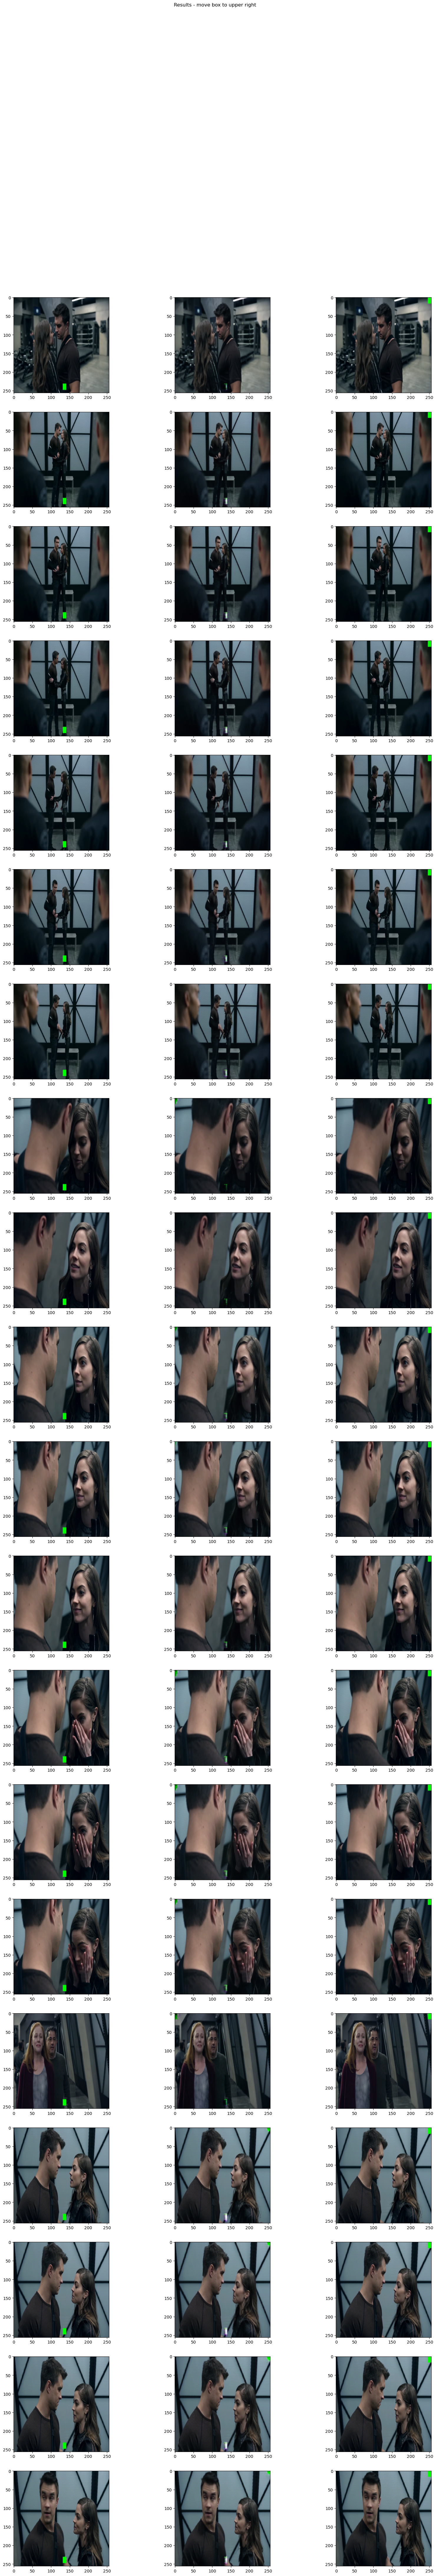

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

values = output_pictures(limit=20, start_image=15)
print(len(values))
fig, axs = plt.subplots(len(values),3)
fig.suptitle('Results - move box to upper right')

fig.set_size_inches(20, 100)
element = 0
for key, item in values.items():
    for pkey, pitem in item.items():
        if pkey == start:
            axs[element, 0].imshow(pitem)
        if pkey == fake:
            axs[element, 1].imshow(pitem)
        if pkey == target:
            axs[element, 2].imshow(pitem)
    element += 1
# axs[0, 0].imshow(img)
# axs[0, 1].imshow(img)
plt.show()

{'1850': {'fake': array([[[0.05490196, 0.17254902, 0.05490196],
          [0.03137255, 0.16862746, 0.03137255],
          [0.04705882, 0.20784314, 0.04705882],
          ...,
          [0.03921569, 0.03529412, 0.03137255],
          [0.03529412, 0.03529412, 0.02745098],
          [0.04313726, 0.04705882, 0.03921569]],
  
         [[0.02745098, 0.10980392, 0.03529412],
          [0.01568628, 0.11764706, 0.01568628],
          [0.02352941, 0.13725491, 0.02745098],
          ...,
          [0.02352941, 0.01960784, 0.02352941],
          [0.01568628, 0.01568628, 0.01960784],
          [0.01960784, 0.01960784, 0.01960784]],
  
         [[0.02745098, 0.13333334, 0.03529412],
          [0.01568628, 0.10980392, 0.02352941],
          [0.01960784, 0.13725491, 0.02745098],
          ...,
          [0.01960784, 0.02352941, 0.02745098],
          [0.01568628, 0.01960784, 0.02352941],
          [0.01960784, 0.02745098, 0.02745098]],
  
         ...,
  
         [[0.02352941, 0.01568628, 0.02352941]

In [4]:
import torch
import torchvision.ops as ops

def bbox_iou(box1, box2):
    # Compute the Intersection over Union (IoU) of two bounding boxes
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    intersection_area = max(x_max - x_min, 0) * max(y_max - y_min, 0)
    union_area = area1 + area2 - intersection_area

    iou = intersection_area / union_area
    return iou

def filter_similar_boxes(bboxes, labels, scores, iou_threshold=0.8):
    # Initialize lists to store the filtered bounding boxes and their corresponding labels
    filtered_bboxes = []
    filtered_labels = []
    seen_boxes = set()

    # Iterate through the bounding boxes and keep only those with the highest score for each similar box group
    for i in range(len(bboxes)):
        box_i = bboxes[i]
        label_i = labels[i]
        score_i = scores[i]

        skip_box = False
        for seen_box, seen_label in seen_boxes:
            iou = bbox_iou(box_i, seen_box)
            if iou > iou_threshold:
                skip_box = True
                if score_i > scores[seen_label]:
                    # Update the seen box if the current box has a higher score
                    seen_boxes.remove((seen_box, seen_label))
                    seen_boxes.add((box_i, i))
                break

        if not skip_box:
            seen_boxes.add((box_i, i))
    
    # Extract the filtered boxes and labels from the seen_boxes set
    for box, label_idx in seen_boxes:
        filtered_bboxes.append(bboxes[label_idx])
        filtered_labels.append(labels[label_idx])
    
    # Convert the lists to torch tensors
    filtered_bboxes = torch.stack(filtered_bboxes)
    filtered_labels = torch.tensor(filtered_labels)

    return filtered_bboxes, filtered_labels

# Sample data
bboxes = torch.tensor([[144.4520, 79.2710, 358.1183, 341.4197],
                       [394.9118, 108.9555, 639.3996, 443.6320],
                       [394.9118, 98.9555, 639.3996, 443.6320],
                       [144.4520, 69.2710, 358.1183, 341.4197]])

labels = torch.tensor([1, 1, 2, 2])
scores = torch.tensor([0.8465, 0.5934, 0.5465, 0.3232])

# Filter the bounding boxes and labels based on the highest scores and similarity threshold
filtered_bboxes, filtered_labels = filter_similar_boxes(bboxes, labels, scores)

print("Filtered Bounding Boxes:")
print(filtered_bboxes)

print("\nFiltered Labels:")
print(filtered_labels)

Filtered Bounding Boxes:
tensor([[144.4520,  79.2710, 358.1183, 341.4197],
        [394.9118, 108.9555, 639.3996, 443.6320]])

Filtered Labels:
tensor([1, 1])


In [10]:
import os

folder_path = 'E:\Python\MasterThesis\AutomaticSubtitlePlacement\data\subtitle_position_boxes_start_of_subtitle'

text_middle_array = ["A film sequence featuring a subtitle indicator located at the center bottom of the screen.", 
                     "In a cinematic moment, a scene is depicted with a subtitle marker positioned at the middle bottom of the frame."
                     "Within a movie scene, a subtitle position marker is situated at the bottom center of the visual composition.", 
                     "In the midst of a film scene, a marker indicating subtitle placement is positioned at the frame's lower middle."
                     "A scene from a movie showing a subtitle indicator placed in the middle of the bottom part of the frame.",
                     "Embedded in a movie scene is a subtitle position marker situated at the center of the lower frame.",
                     "In the context of a movie scene, a subtitle position marker is found at the frame's middle bottom.", 
                     "A film sequence displays a subtitle position marker located in the center at the bottom of the frame.",
                     "In a movie's scene, a marker denoting subtitle position is positioned at the frame's middle bottom.", 
                     "Within a film scene, a subtitle position marker appears at the bottom middle of the frame"]

text_empty_array = [
    "In this action movie scene, the speaker who's currently active is engaged in conversation.",
    "Within the action movie, we see a scene where the person currently speaking is involved in a dialogue.",
    "A moment from the action film shows the active speaker engaged in talking.",
    "The active speaker is in a conversation during a scene from the action movie.",
    "In the action movie scene, the speaker who's currently talking takes the spotlight.",
    "Within this scene of the action movie, the speaker currently talking is the focus.",
    "We're presented with a scene from the action movie featuring the active speaker talking.",
    "In this action movie scene, the one speaking at the moment is having a conversation.",
    "The scene from the action movie captures the active speaker in the midst of talking.",
    "Within the action movie scene, we observe the currently active speaker engaged in speech."
]

text_positioned_array = [
    "In a film scene, a subtitle indicator is strategically placed near the current frame's active speaker, ensuring no important visual details are obscured.",
    "Within a movie scene, a subtitle positioning marker is placed in proximity to the current frame's speaker, without obstructing pertinent visual elements.",
    "A scene in a movie features a subtitle position marker positioned near the speaking character of the frame, maintaining visibility of crucial visual content.",
    "In the context of a film scene, a subtitle position marker is carefully situated close to the active speaker in the frame, without blocking any significant visual elements.",
    "A film sequence includes a subtitle positioning marker placed near the frame's active speaker, while keeping important visual information unobscured.",
    "Within a movie scene, a subtitle position marker is positioned adjacent to the speaking character of the current frame, with no interference to essential visual elements.",
    "In a cinematic scene, a subtitle position marker is strategically located near the frame's speaker, preserving the visibility of pertinent visual details.",
    "A scene from a movie showcases a subtitle positioning marker positioned in close proximity to the active speaker within the frame, all without obstructing key visual content.",
    "Within a film scene, a subtitle position marker is placed near the speaking character of the current frame, ensuring that relevant visual information remains unhidden.",
    "In the setting of a movie scene, a subtitle position marker is placed close to the active speaker of the current frame, while not obstructing any important visual details."
]
                     
result_train = {}
result_val = {}
result_test = {}
id_train = 0
id_val = 0
id_test = 0
id=0
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if not "combined" in root and not "\\_A\\" in root:
            file_path = os.path.join(root, file)
            if r"\\A\\" in root:
                text = text_middle_array[id%10]
            else:
                text = text_positioned_array[id%10]
            
            if "\\train" in file_path:
                result_train[id_train] = [file_path, text]
                id_train += 1
            elif "\\test\\" in file_path:
                result_test[id_test] = [file_path, text]
                id_test +=1
            else:
                result_val[id_val] = [file_path, text]
                id_val += 1
            text = None
            id +=1

In [11]:
import json

base_path = "E:\Python\MasterThesis\Open-Edit\dataset\SWAT\OpenEdit_subtitle_position_boxes_start_of_subtitle_middle"

with open(base_path + "\\train.json", "w") as json_file:
    json.dump(result_train, json_file)

with open(base_path + "\\test.json", "w") as json_file:
    json.dump(result_test, json_file)
    
with open(base_path + "\\val.json", "w") as json_file:
    json.dump(result_val, json_file)

In [28]:
"\\test\\" in 'E:\\Python\\MasterThesis\\AutomaticSubtitlePlacement\\data\\subtitle_position_boxes_middle_of_subtitle\\A\\test\\2269.jpg'

True

In [30]:
result_test

{0: ['E:\\Python\\MasterThesis\\AutomaticSubtitlePlacement\\data\\subtitle_position_boxes_middle_of_subtitle\\A\\test\\2250.jpg',
  "In a film scene, a subtitle indicator is strategically placed near the current frame's active speaker, ensuring no important visual details are obscured."],
 1: ['E:\\Python\\MasterThesis\\AutomaticSubtitlePlacement\\data\\subtitle_position_boxes_middle_of_subtitle\\A\\test\\2251.jpg',
  "Within a movie scene, a subtitle positioning marker is placed in proximity to the current frame's speaker, without obstructing pertinent visual elements."],
 2: ['E:\\Python\\MasterThesis\\AutomaticSubtitlePlacement\\data\\subtitle_position_boxes_middle_of_subtitle\\A\\test\\2252.jpg',
  'A scene in a movie features a subtitle position marker positioned near the speaking character of the frame, maintaining visibility of crucial visual content.'],
 3: ['E:\\Python\\MasterThesis\\AutomaticSubtitlePlacement\\data\\subtitle_position_boxes_middle_of_subtitle\\A\\test\\2253.jp

In [9]:
from pycocotools.mask import decode


decoded = decode([{"size": [1080,1920], "counts": "0PPYo1"}])

In [11]:
decoded.shape

(1080, 1920, 1)

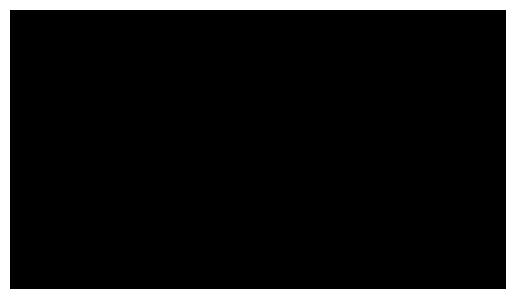

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Display the image using matplotlib
plt.imshow(decoded.squeeze(), cmap='gray')  # Squeeze to remove the single channel dimension
plt.axis('off')  # Turn off axis labels
# plt.savefig('output_image.png', bbox_inches='tight', pad_inches=0, dpi=300)  # Save as PNG
plt.show()